<a href="https://colab.research.google.com/github/1oneweeek/TIL/blob/main/torch_week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3주차

코딩목표: 1-2주차 내용을 발전시켜보기

코드 모듈화

argparser 추가

loss와 accuracy에 대한 log 출력, 시각화

100%|██████████| 9912422/9912422 [00:00<00:00, 110150966.49it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 18202207.94it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31774119.93it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4726005.65it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 170498071/170498071 [00:02<00:00, 84343623.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[1,   100] loss: 1.270
[1,   200] loss: 0.912
[1,   300] loss: 0.807
[1,   400] loss: 0.779
[1,   500] loss: 0.703
[1,   600] loss: 0.717
[1,   700] loss: 0.667
[1,   800] loss: 0.654
[1,   900] loss: 0.645
[1,  1000] loss: 0.619
[1,  1100] loss: 0.601
[1,  1200] loss: 0.570
[1,  1300] loss: 0.563
[1,  1400] loss: 0.579
[1,  1500] loss: 0.558
[1,  1600] loss: 0.543
[1,  1700] loss: 0.529
[2,   100] loss: 0.459
[2,   200] loss: 0.482
[2,   300] loss: 0.484
[2,   400] loss: 0.485
[2,   500] loss: 0.494
[2,   600] loss: 0.468
[2,   700] loss: 0.457
[2,   800] loss: 0.445
[2,   900] loss: 0.458
[2,  1000] loss: 0.441
[2,  1100] loss: 0.461
[2,  1200] loss: 0.434
[2,  1300] loss: 0.454
[2,  1400] loss: 0.459
[2,  1500] loss: 0.432
[2,  1600] loss: 0.420
[2,  1700] loss: 0.416
[3,   100] loss: 0.350
[3,   200] loss: 0.367
[3,   300] loss: 0.342
[3,   400] loss: 0.372
[3,   500] loss: 0.386
[3,   600] loss: 0.363
[3,   700] loss: 0.377
[3,   800] loss: 0.369
[3,   900] loss: 0.352
[3,  1000] 

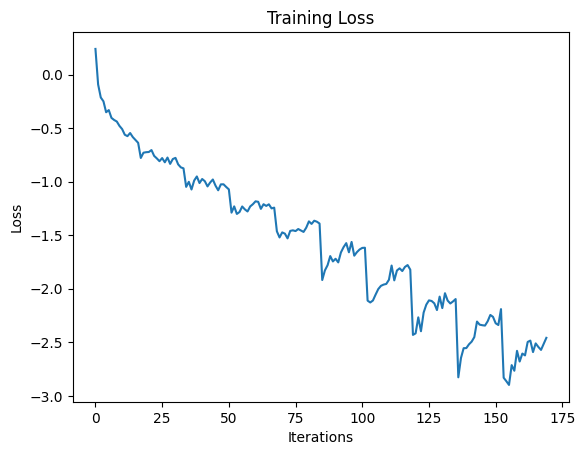

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, Dataset

import argparse
import sys
import matplotlib.pyplot as plt

# 1. CustomDataset으로 데이터 load
class CustomDataset(Dataset):
    def __init__(self, dataset1, dataset2, transform=None):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.transform = transform

    def __len__(self):
        return len(self.dataset1) + len(self.dataset2)

    def __getitem__(self, idx):
        if idx < len(self.dataset1):
            img, label = self.dataset1[idx]
        else:
            img, label = self.dataset2[idx - len(self.dataset1)]
        if self.transform:
            img = self.transform(img)
        return img, label

# 모듈화 - datasets
# 데이터 전처리: MNIST와 CIFAR-10 입력 크기 맞춰주기
def datasets():
    transform_mnist = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    transform_cifar = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# MNIST, CIFAR-10 데이터셋을 불러온 다음 하나로 합침
    trainset_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
    testset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

    trainset_cifar = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
    testset_cifar = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

    trainset = CustomDataset(trainset_mnist, trainset_cifar)
    testset = CustomDataset(testset_mnist, testset_cifar)

    return trainset, testset

# 2. 모델 정의
# 모듈화 - create_model
def cmodel():
    model = torchvision.models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3), bias=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 20)
    return model

import numpy as np

# 모듈화 - train
def train(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
                losses.append(np.log(running_loss / 100))  # 매 배치마다의 손실(loss)를 log scale로 변환하고 저장
                running_loss = 0.0
    print('Finished Training')
    return losses


# 모듈화 - test
def test(model, test_loader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# 모듈화 - main
def main(args):
    trainset, testset = datasets()
    train_loader = DataLoader(trainset, batch_size=args.batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=args.batch_size, shuffle=False)

    model = cmodel()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    losses = train(model, train_loader, criterion, optimizer, device, num_epochs=args.epochs)
    accuracy = test(model, test_loader, device)
    print('모델 정확도: {:.2f}%'.format(accuracy))

    # Loss 그래프 시각화
    plt.plot(losses)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

if __name__ == '__main__':
    # 노트북에서 argparse을 사용하기 위한 코드
    sys.argv = ['']
    parser = argparse.ArgumentParser(description='MNIST와 CIFAR 데이터 학습')
    parser.add_argument('--batch-size', type=int, default=64, help='배치 크기 (기본값: 64)')
    parser.add_argument('--lr', type=float, default=0.01, help='학습률 (기본값: 0.01)')
    parser.add_argument('--epochs', type=int, default=10, help='에폭 수 (기본값: 10)')
    args = parser.parse_args()

    main(args)
